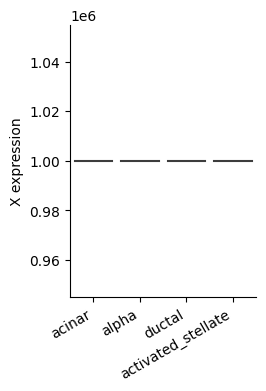

In [29]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64

def sql_query(query):
    # postgres data retrieval with consistent output, both in the jupyter development
    # environment and at runtime inside a plpython3u stored procedure
    try:
        import plpy
    except:
        from postgres_utils import engine
        from sqlalchemy import text
        with engine.connect() as connection:
            r = connection.execute(text(query))            
            return [row._mapping for row in r.fetchall()]
    
    r = plpy.execute(query)
    return [row for row in r]

def get_annotated_samples_expression():
    expression_records = sql_query("""
        select e.omics_id, e.study_sample_ids, e.values
            from expression e
        where e.study_layer_id=1 and e.omics_id=1000000""")
    df = pd.DataFrame(expression_records)
    samples_expression_df = df.explode('study_sample_ids').drop(columns=['values'])
    samples_expression_df['value'] = df.explode('values')['values']
    samples_expression_df

    sample_annotation_records = sql_query("""
        select av.display_value, array_agg(ssa.study_sample_id) study_sample_ids
        from annotation a
                 join annotation_value av on av.annotation_id = a.annotation_id
                 join study_sample_annotation ssa on av.annotation_value_id = ssa.annotation_value_id
        where a.h5ad_column = 'celltype' and ssa.study_id=1
        group by av.annotation_value_id;  """)
    sample_annotation_df = pd.DataFrame(sample_annotation_records).explode('study_sample_ids').set_index('study_sample_ids')
    sample_annotation_df

    return samples_expression_df.join(sample_annotation_df, on='study_sample_ids')

def seaborn_to_base64() -> str:
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return f"data:image/png;base64,{s}"

# https://stackoverflow.com/questions/41567205/outer-lines-seaborn-violinplot-boxplot
def _patch_violinplot_remove_violin_edge_line(ax):
    from matplotlib.collections import PolyCollection
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor(art.get_facecolor())

def generate_plot():
    df = get_annotated_samples_expression()
    groupByAttribute = 'display_value'

    # code reuse
    unique_x_values = len(df[groupByAttribute].unique())

    # TODO!
    # we need to keep 'not measured' as 0, otherwise scarce expression values lead to a high violin
    # df = df.replace({0: np.nan})
    max_x_values_chars = max([len(name) for name in df[groupByAttribute].unique()])
    fig, ax = plt.subplots(figsize=((unique_x_values * 1.0) * 0.6, (5 + max_x_values_chars * 0.05) * 0.6))
    sns.violinplot(ax=ax, data=df, y='omics_id',
                           x=groupByAttribute, 
                   #order=_get_ordered_attributevalues(df, groupByAttribute),
                           #hue=secondaryGroupByAttribute,
                           #hue_order=_get_ordered_attributevalues(df,
                           #                                       secondaryGroupByAttribute) if secondaryGroupByAttribute else None,
                           #palette=palette,
                           saturation=1,
                           cut=0,
                           scale='width',
                           inner='box')
    # get rid of legend, which shows by default in 'hue' mode
    plt.legend([], [], frameon=False)
    _patch_violinplot_remove_violin_edge_line(ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set(xlabel=None, ylabel=f"X expression")
    sns.despine(fig)

generate_plot()
#seaborn_to_base64()


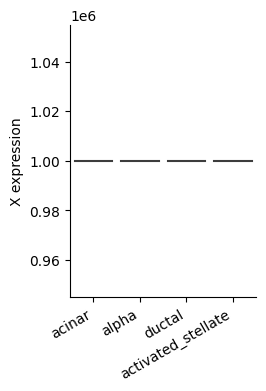

In [27]:
from IPython import display
im = 'data:image/png;base64,.iVBORw0K........'

display.HTML(f'<img src="{im}" />')